## Data science challeng
The dataset contains information on credit card holders. The objective is to estimate the probability of default. The key activities to complete include:

o Takeaways from Data Visualization/Exploration

o Implement any data pre-processing steps, if required

o Explore analytical techniques or models that are appropriate for this use case

o Fit selected model to the analytics ready dataset. List outcomes from model fitting

o Evaluate model performance on held-out/testing dataset

o What other options would you’ve considered (in solving the problem), if you had additional time?

In [1]:
# import common libraries
import os
import pandas as pd
import numpy as np
# from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler,FunctionTransformer,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import roc_curve, auc,classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import average_precision_score,precision_recall_curve,plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, cross_val_score


## Read data and clean data

In [2]:
df = pd.read_excel('data.xls',index_col=0)
print(df.head(3))
# df.describe().transpose()
# df.dtypes

col1 = df.columns.values
col2 = df.iloc[0].values
print(col1)
print(col2)

# check if dataset has any missing dtaa
if df.isnull().values.any():
    print("fill missing value!")
else:
    print("no missing value")

# drop the column name row
df = df.drop(['ID'],axis=0)

# cast data to type int64
df = df.apply(lambda col:pd.to_numeric(col, errors='coerce'))

# class 1 default, class 0 non default
df1 = df[df['Y']==1]
df0 = df[df['Y']==0]

print(df1.shape[0], 'out of', df.shape[0], 'Dataset is default ' + '{:.2%}'.format(float(df1.shape[0]/df.shape[0])))

# 22% default rate, unbalanced data

           X1   X2         X3        X4   X5     X6     X7     X8     X9  \
ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4   
1       20000    2          2         1   24      2      2     -1     -1   
2      120000    2          2         2   26     -1      2      0      0   

      X10  ...        X15        X16        X17       X18       X19       X20  \
ID  PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3   
1      -2  ...          0          0          0         0       689         0   
2       0  ...       3272       3455       3261         0      1000      1000   

         X21       X22       X23                           Y  
ID  PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
1          0         0         0                           1  
2       1000         0      2000                           1  

[3 rows x 24 columns]
['X1' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'X8' 'X9' 'X10' 'X11' 'X12' 'X13'
 'X14' 'X15' 'X16' 'X17' 

## Explore dataset
dataset correlation matrix shows strong correlation within X11-X17, using regression model need feature selection

### Comparing Class 1(default) and Class 0(no default), 
- default has lower credit limit then no-default
- default and no-default group has similar age distribution
- X3- education, 0,5,6 is unknown categories
- X4- mariage, 0 is unknown category
- X6-X11: Repayment status (-2=no consumption, -1=pay duly, 0=the use of revolving credit, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
- default group repayment status has higher value than no-default group, tend to use more credit, borrow more
- X12-X17: amount of bill statement is increasing from April to September
- X18-X23: no-default group has higher amount of payment, and payment is increasing from April to September


In [3]:
# check the correlation matrix to find collinearity
df.corr()
# X12 X13 X14 x15 X16 X17 are highly correlated

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
X1,1.000000,0.024755,-0.219161,-0.108139,0.144713,-0.271214,-0.296382,-0.286123,-0.267460,-0.249411,...,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520
X2,0.024755,1.000000,0.014232,-0.031389,-0.090874,-0.057643,-0.070771,-0.066096,-0.060173,-0.055064,...,-0.021880,-0.017005,-0.016733,-0.000242,-0.001391,-0.008597,-0.002229,-0.001667,-0.002766,-0.039961
X3,-0.219161,0.014232,1.000000,-0.143464,0.175061,0.105364,0.121566,0.114025,0.108793,0.097520,...,-0.000451,-0.007567,-0.009099,-0.037456,-0.030038,-0.039943,-0.038218,-0.040358,-0.037200,0.028006
X4,-0.108139,-0.031389,-0.143464,1.000000,-0.414170,0.019917,0.024199,0.032688,0.033122,0.035629,...,-0.023344,-0.025393,-0.021207,-0.005979,-0.008093,-0.003541,-0.012659,-0.001205,-0.006641,-0.024339
X5,0.144713,-0.090874,0.175061,-0.414170,1.000000,-0.039447,-0.050148,-0.053048,-0.049722,-0.053826,...,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478,0.013890
X6,-0.271214,-0.057643,0.105364,0.019917,-0.039447,1.000000,0.672164,0.574245,0.538841,0.509426,...,0.179125,0.180635,0.176980,-0.079269,-0.070101,-0.070561,-0.064005,-0.058190,-0.058673,0.324794
X7,-0.296382,-0.070771,0.121566,0.024199,-0.050148,0.672164,1.000000,0.766552,0.662067,0.622780,...,0.222237,0.221348,0.219403,-0.080701,-0.058990,-0.055901,-0.046858,-0.037093,-0.036500,0.263551
X8,-0.286123,-0.066096,0.114025,0.032688,-0.053048,0.574245,0.766552,1.000000,0.777359,0.686775,...,0.227202,0.225145,0.222327,0.001295,-0.066793,-0.053311,-0.046067,-0.035863,-0.035861,0.235253
X9,-0.267460,-0.060173,0.108793,0.033122,-0.049722,0.538841,0.662067,0.777359,1.000000,0.819835,...,0.245917,0.242902,0.239154,-0.009362,-0.001944,-0.069235,-0.043461,-0.033590,-0.026565,0.216614
X10,-0.249411,-0.055064,0.097520,0.035629,-0.053826,0.509426,0.622780,0.686775,0.819835,1.000000,...,0.271915,0.269783,0.262509,-0.006089,-0.003191,0.009062,-0.058299,-0.033337,-0.023027,0.204149


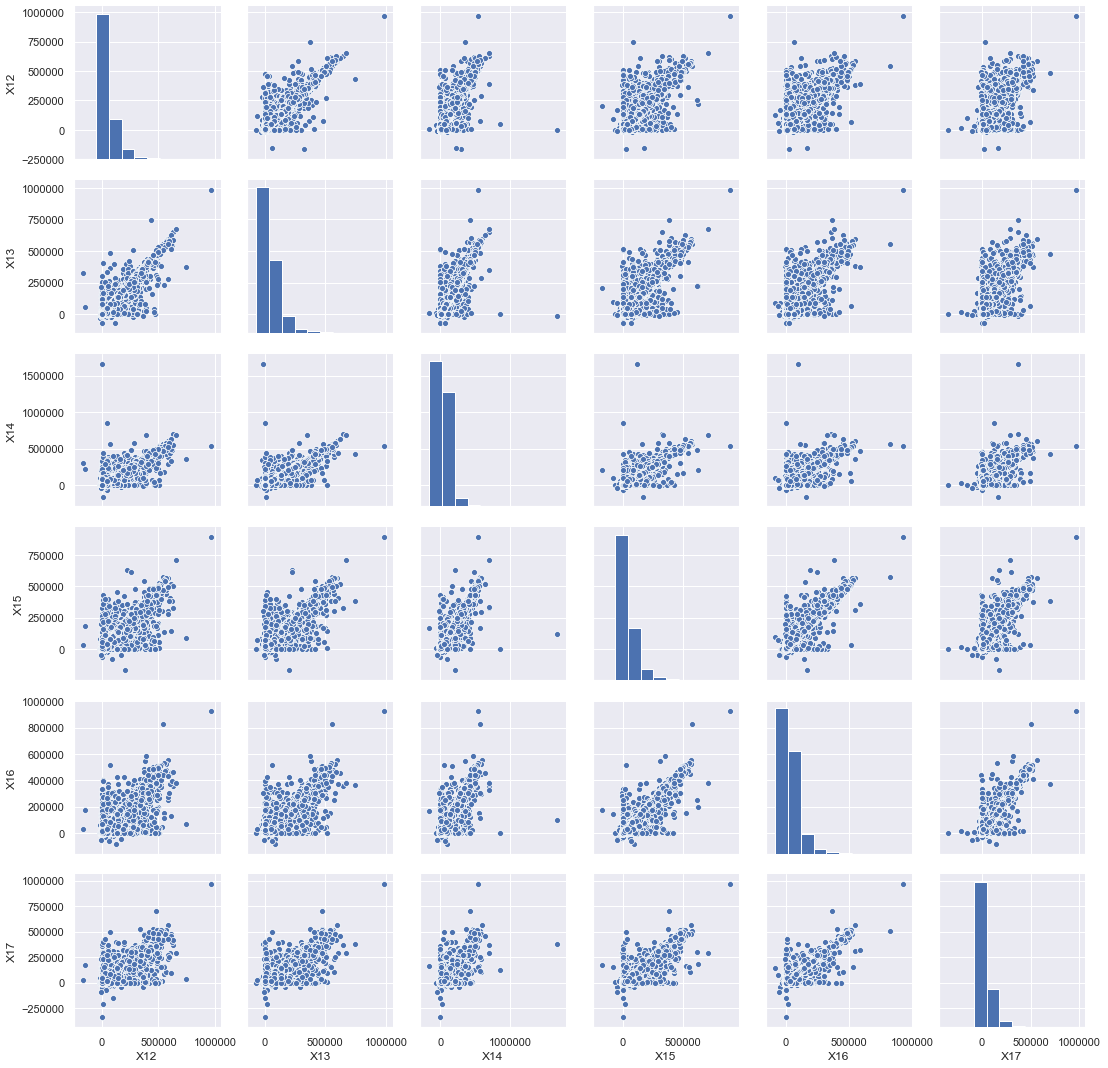

In [4]:
# plot columns[X12-X17] with similar names to check the correlation
sns.pairplot(df, vars=df.columns[11:17], kind='scatter')
# plots showed correlations between each other, may need feature selection if using regression

In [5]:
# describe dataset
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X1,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
X2,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
X3,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
X4,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
X5,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
X6,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
X7,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
X8,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
X9,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
X10,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


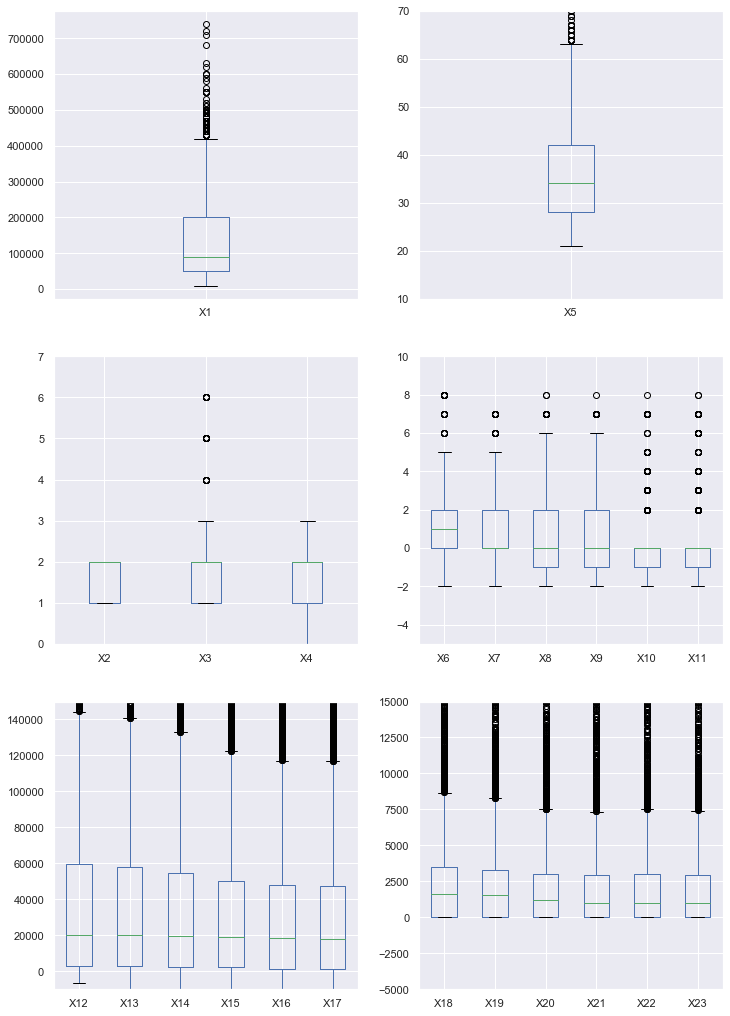

In [6]:
# look at class 1 (default) data boxplot, ignore categorical columns
fig, axes = plt.subplots(figsize=(12,18),nrows=3, ncols=2)

df1.boxplot(column=['X1'],ax=axes[0,0])
axes[0,1].set_ylim(10, 70)
df1.boxplot(column=['X5'],ax=axes[0,1])
axes[1,0].set_ylim(0, 7)
df1.boxplot(column=['X2', 'X3', 'X4'],ax=axes[1,0])
axes[1,1].set_ylim(-5, 10)
df1.boxplot(column=['X6', 'X7', 'X8', 'X9', 'X10', 'X11'],ax=axes[1,1])
axes[2,0].set_ylim(-10000, 150000)
df1.boxplot(column=['X12', 'X13', 'X14', 'X15', 'X16', 'X17'],ax=axes[2,0])
axes[2,1].set_ylim(-5000, 15000)
df1.boxplot(column=['X18', 'X19', 'X20', 'X21', 'X22', 'X23'],ax=axes[2,1])

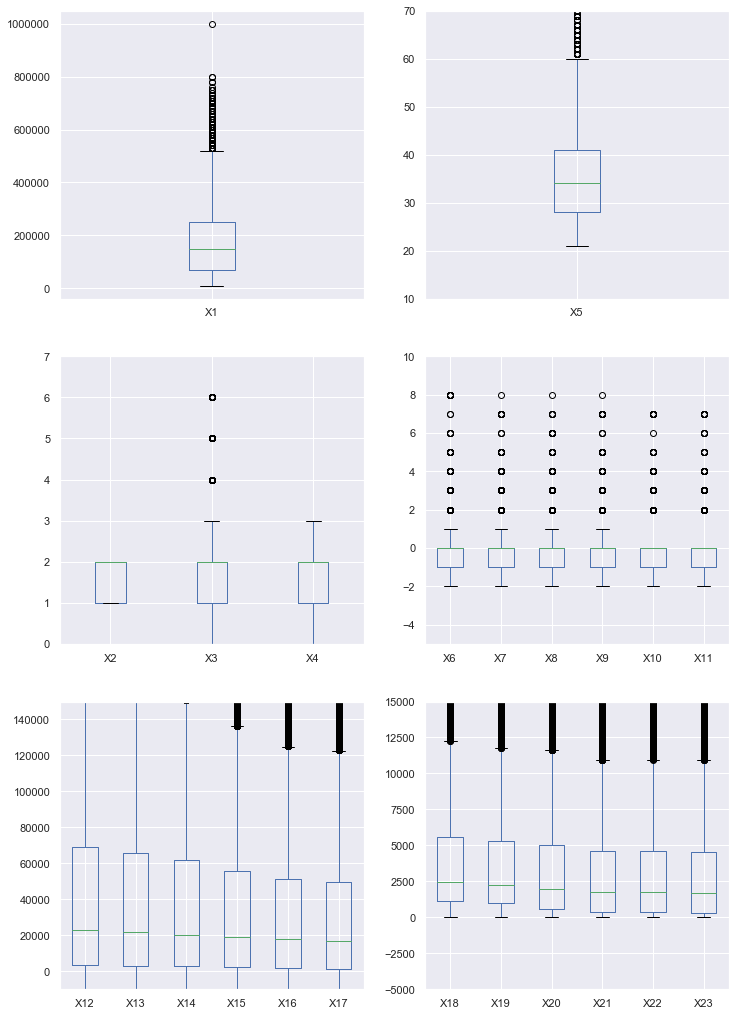

In [7]:
# look at class 0 (not default) data boxplot
fig, axes = plt.subplots(figsize=(12,18),nrows=3, ncols=2)

df0.boxplot(column=['X1'],ax=axes[0,0])
axes[0,1].set_ylim(10, 70)
df0.boxplot(column=['X5'],ax=axes[0,1])
axes[1,0].set_ylim(0, 7)
df0.boxplot(column=['X2', 'X3', 'X4'],ax=axes[1,0])
axes[1,1].set_ylim(-5, 10)
df0.boxplot(column=['X6', 'X7', 'X8', 'X9', 'X10', 'X11'],ax=axes[1,1])
axes[2,0].set_ylim(-10000, 150000)
df0.boxplot(column=['X12', 'X13', 'X14', 'X15', 'X16', 'X17'],ax=axes[2,0])
axes[2,1].set_ylim(-5000, 15000)
df0.boxplot(column=['X18', 'X19', 'X20', 'X21', 'X22', 'X23'],ax=axes[2,1])

## Data pre-process
- Standardize numeric features
- convert categorical features into dummy features using scikit
- split tran(70%) and test(30%) dataset


In [8]:
# standardize numeric features
# cols = df.columns[11:23]
cols= ['X1', 'X5', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18' ,'X19', 'X20', 'X21' ,'X22' ,'X23']

# df[cols]=df[cols].apply(lambda x: (x-np.mean(x)/np.std(x)))

scaler = StandardScaler()
df[cols] = scaler.fit_transform(df[cols])
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
1,-1.136720,2,2,1,-1.246020,2,2,-1,-1,-2,...,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,1
2,-0.365981,2,2,2,-1.029047,-1,2,0,0,0,...,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,1
3,-0.597202,2,2,2,-0.161156,0,0,0,0,0,...,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,0
4,-0.905498,2,2,1,0.164303,0,0,0,0,0,...,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,0
5,-0.905498,1,2,1,2.334029,-1,0,-1,0,0,...,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187,0


In [9]:
# Encode categorical features 
X= df.iloc[:,0:23].values
y = df.Y.values
ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'), [1,2,3,5,6,7,8,9,10])],  
    remainder='passthrough'                                         
)
X = ct.fit_transform(X)
X

# 1,2,3,5,6,7,8,9,10

<30000x91 sparse matrix of type '<class 'numpy.float64'>'
	with 690000 stored elements in Compressed Sparse Row format>

In [10]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df.Y.values, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(21000, 91) (21000,)
(9000, 91) (9000,)


## Define utility functions
- grid search utility function
- prediction confusion matrix
- plot roc curve

In [11]:
# Define function to optimize model based on roc_auc 
# (for unbalanced classes, roc_auc makes more sence since the accuracy score can be fooled by only predicting 0)

def gridsearch(model, params):
    gs = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1)
    gs.fit(X_train, y_train)
    print('Best params: ', gs.best_params_)
    print('Best auc on training set: ', gs.best_score_)
    print('Best auc on test set: ', gs.score(X_test, y_test))
    return gs.predict(X_test), gs.decision_function(X_test), gs.best_params_

In [12]:
# Define function to generate confusion matrix

def print_confusion(prediction):
    conmat = np.array(confusion_matrix(y_test, prediction, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['default', 'not default'], 
                             columns=['predicted default', 'predicted not default'])
    print(confusion)

In [13]:
# Define function to plot roc curve

def plot_roc(prob):
    y_score = prob
    fpr = dict()
    tpr = dict()
    roc_auc=dict()
    fpr[1], tpr[1], _ = roc_curve(y_test, y_score)
    roc_auc[1] = auc(fpr[1], tpr[1])

    plt.figure(figsize=[7,5])
    plt.plot(fpr[1], tpr[1], label='Roc curve (area=%0.2f)' %roc_auc[1], linewidth=4)
    plt.plot([1,0], [1,0], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('false positive rate', fontsize=18)
    plt.ylabel('true positive rate', fontsize=18)
    plt.title('ROC curve for credit default', fontsize=18)
    plt.legend(loc='lower right')
    plt.show()

## SGD

In [14]:
# try using stochastic gradient descent with logistic loss function
# set penalty l1 to select features and address multicollinearity issues
sgd_loss = 'log'
sgd_penalty = 'l1'
sgd_learning_rate = 'optimal'

sgd = SGDClassifier(loss=sgd_loss, penalty=sgd_penalty, learning_rate=sgd_learning_rate)

# use grid search to optimize parameters
sgd_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0], 'class_weight': [None, 'balanced']}

sgd_pred, sgd_prob, sgd_parm = gridsearch(sgd, sgd_params)

# Check the accuracy score
sgd = SGDClassifier(loss=sgd_loss, penalty=sgd_penalty, learning_rate=sgd_learning_rate, 
                    alpha=sgd_parm['alpha'], class_weight= sgd_parm['class_weight'])

print('accuracy score on training set: ', cross_val_score(sgd, X_train, y_train, n_jobs=-1).mean())
print('accuracy score on testing set: ', accuracy_score(sgd_pred, y_test))

Best params:  {'alpha': 0.001, 'class_weight': 'balanced'}
Best auc on training set:  0.7632158720056444
Best auc on test set:  0.7675353400474773
accuracy score on training set:  0.7779047619047619
accuracy score on testing set:  0.7826666666666666


In [24]:
# create classification report
print(classification_report(y_test, sgd_pred, target_names=['not default', 'default']))

              precision    recall  f1-score   support

 not default       0.87      0.85      0.86      7009
     default       0.51      0.55      0.53      1991

    accuracy                           0.78      9000
   macro avg       0.69      0.70      0.69      9000
weighted avg       0.79      0.78      0.79      9000



In [17]:
# create confusion matrix
print_confusion(sgd_pred)

             predicted default  predicted not default
default                   1094                    897
not default               1059                   5950


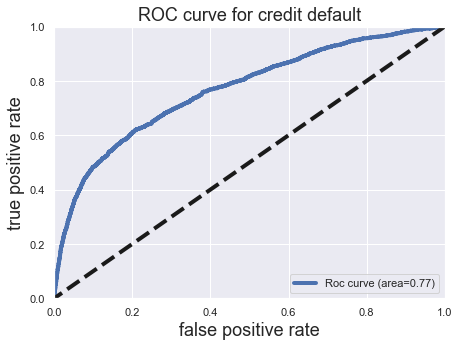

In [18]:
# plot roc curve and calculate auc
plot_roc(sgd_prob)

Text(0.5, 1.0, 'SGD Precision-Recall curve: AP=0.54')

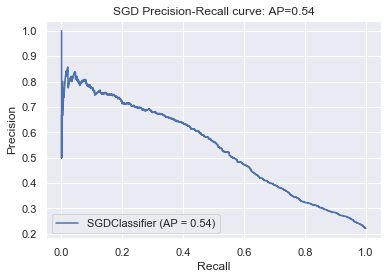

In [15]:
# plot precision recall plot

model = sgd.fit(X_train, y_train)

average_precision = average_precision_score(y_test, sgd_prob)

disp = plot_precision_recall_curve(sgd, X_test, y_test)
disp.ax_.set_title('SGD Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

## Logistic Regression with manual feature selection

In [19]:
# logistic regression with grid search
lr_solver = 'liblinear'

lr = LogisticRegression(solver=lr_solver)
lr_params = {'C': [0.001, 0.01, 0.1, 1, 10], 'class_weight': [None, 'balanced'], 'penalty': ['l1', 'l2']}

lr_pred, lr_prob, lr_parm = gridsearch(lr, lr_params)

# feature selection with the best model from grid search
# roc_auc same as sgdclassifier

lr = LogisticRegression(penalty=lr_parm['penalty'], C= lr_parm['C'], 
                        solver=lr_solver, class_weight=lr_parm['class_weight'])
rfecv = RFECV(estimator=lr, scoring='roc_auc')
model = rfecv.fit(X_train, y_train)
lr_pred = model.predict(X_test)
lr_prob = model.decision_function(X_test)
print('Test score: ', model.score(X_test, y_test))

# Check the accuracy score, much worse than sgdclassifier

print('accuracy score on training set: ', cross_val_score(lr, X_train, y_train, n_jobs=-1).mean())
print('accuracy score on testing set: ', accuracy_score(lr_pred, y_test))

Best params:  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}
Best auc on training set:  0.7669714840828114
Best auc on test set:  0.7721159829017997
Test score:  0.7726666666666666
accuracy score on training set:  0.7789047619047619
accuracy score on testing set:  0.7726666666666666


In [20]:
# print confusion matrix
# the model catches more default, but made more mistake in identifying non default at the same time
# So if the bank cares more about identifying people who are going to default (more conservative), 
# this model may be a better choice. If the bank is more aggressive, go for the first one.
print_confusion(lr_pred)

             predicted default  predicted not default
default                   1135                    856
not default               1190                   5819


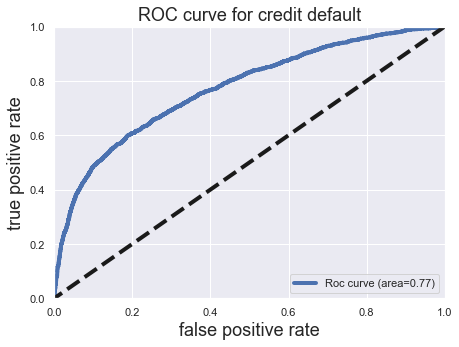

In [21]:
# plot roc curve
plot_roc(lr_prob)

Text(0.5, 1.0, 'Logistic Precision-Recall curve: AP=0.54')

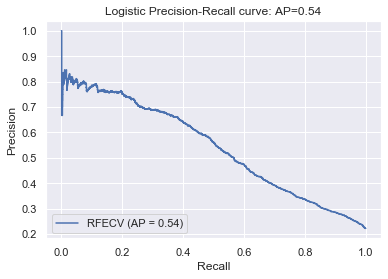

In [22]:
# plot precision recall plot
average_precision = average_precision_score(y_test, lr_prob)

disp = plot_precision_recall_curve(rfecv, X_test, y_test)
disp.ax_.set_title('Logistic Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))